In [1]:
#pip install yfinance pandas matplotlib numpy


Installs all the libraries
Titel Df 'voo' for the Vanguard S&P Index that I use to invest.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

The Data goes from 01/04/2010 to 12/30/2024

*   Columns in voo:
1.   Date
2.   Close (SPY)
3.   High (SPY)
4.   Low (SPY)
5.   Open (SPY)
6.   Volume (SPY)








Now I want to define trading signals:  
*   Momentum signal (negative return over 3 days)
*   Volatility filter (low rolling standard deviation over 10 days).



Now I want to Create a signal if the above criteria are met it assigns a value of true, which means I but that day. For this analysis we will assume we buy at market close every day.

Buy if Signal is 1, else 0 (not trading)

Calculate the Sharpe Ratio (annualized for 252 trading days in a year).

#Functions

In [3]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    drawdown_val = (cumulative / cumulative.cummax()) - 1
    return drawdown_val * 100

def compute_metrics(ret_series,rate=0):
    rate = float(rate) if isinstance(rate, str) else rate
    cum_ret = (1 + ret_series).cumprod()
    sharpe = (ret_series.mean() -rate/100/252)/ ret_series.std() * np.sqrt(252) if ret_series.std() != 0 else 0
    final_value = cum_ret.iloc[-1]
    num_years = (ret_series.index[-1] - ret_series.index[0]).days / 365.25
    cagr = final_value ** (1 / num_years) - 1
    draw = drawdown(ret_series)
    max_drawdown = draw.min()
    return round(sharpe,2), round(cagr * 100,1), round(max_drawdown,1)
def format_percent_cols(df):
    df_fmt = df.copy()
    df_fmt['CAGR'] = df_fmt['CAGR'].map('{:.1f}%'.format)
    df_fmt['Max Draw'] = df_fmt['Max Draw'].map('{:.1f}%'.format)
    return df_fmt

def add_momentum_features(df, window):
    df = df.copy()
    df['Change'] = df['Close'].pct_change()
    df['Momentum'] = df['Close'].pct_change(window)
    df['sd'] = df['Change'].rolling(window).std()
    return df
def parse_date(input_str, default):
    if input_str == "":
        return default
    try:
        return datetime.strptime(input_str, "%m/%d/%y").strftime("%Y-%m-%d")
    except ValueError:
        print("❌ Invalid date format. Use MM/DD/YY like 1/1/15.")
        exit()

In [4]:
def momentum_strategy(stock, sort='CAGR', rate=0):
    stock_original = stock.copy()
    ride_results = []
    dip_results = []
    buy_and_hold_results = []
    # Buy and Hold strategy
    stock_bh = stock_original.copy()
    stock_bh['Change'] = stock_bh['Close'].pct_change().dropna()
    sharpe_bh, cagr_bh, max_draw_bh = compute_metrics(stock_bh['Change'])
    buy_and_hold_results.append({
        'Window': 'N/A',
        'Vol': 'N/A',
        'Sharpe': sharpe_bh,
        'CAGR': cagr_bh,
        'Max Draw': max_draw_bh
    })
    buy_and_hold = pd.DataFrame(buy_and_hold_results)
    for momentum_window in range(2, 10):
        stock_window = add_momentum_features(stock_original, momentum_window)
        for vol_threshold in np.arange(0.01, 0.10, 0.01):
            # Ride the momentum
            ride_signal = ((stock_window['Momentum'] > 0) & (stock_window['sd'] < vol_threshold)).shift(1).fillna(0)
            ride_ret = ride_signal * stock_window['Change']
            sharpe_r, cagr_r, max_draw_r = compute_metrics(ride_ret,rate)
            ride_results.append({
                'Window': momentum_window,
                'Vol': round(vol_threshold,2),
                'Sharpe': sharpe_r,
                'CAGR': cagr_r,
                'Max Draw': max_draw_r
            })
            # Dip buying
            dip_signal = ((stock_window['Momentum'] < 0) & (stock_window['sd'] < vol_threshold)).shift(1).fillna(0)
            dip_ret = dip_signal * stock_window['Change']
            sharpe_d, cagr_d, max_draw_d = compute_metrics(dip_ret,rate)
            dip_results.append({
                'Window': momentum_window,
                'Vol': round(vol_threshold,2),
                'Sharpe': sharpe_d,
                'CAGR': cagr_d,
                'Max Draw': max_draw_d
            })

    ride_df = pd.DataFrame(ride_results)
    dip_df = pd.DataFrame(dip_results)
    best_ride = ride_df.sort_values(by=sort, ascending=False).head(1)
    best_dip = dip_df.sort_values(by=sort, ascending=False).head(1)
    best_dip_fmt = format_percent_cols(best_dip)
    best_ride_fmt = format_percent_cols(best_ride)
    buy_and_hold_fmt = format_percent_cols(buy_and_hold)
    output = []
    output.append(f"**RIDE THE MOMENTUM STRATEGY**")
    output.append(tabulate(best_ride_fmt[['Window', 'Vol', 'Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False))
    output.append(f"**DIP BUYING STRATEGY**")
    output.append(tabulate(best_dip_fmt[['Window', 'Vol', 'Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False))
    output.append("**BUY AND HOLD STRATEGY**")
    output.append(tabulate(buy_and_hold_fmt[['Window','Vol','Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False))
    final_output = "\n".join(output)
    return final_output, best_ride, best_dip, buy_and_hold

def plot_drawdown(stock, dip=None, momentum=None):
    stock = stock.copy()
    stock['Change'] = stock['Close'].pct_change()
    cumulative_bh = ((1 + stock['Change']).cumprod()-1)*100
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    # Drawdown Plot (Top Row) with improved colors
    ax_drawdown = axes[0]
    colors_cumulative = ['Black', '#ff7f0e', '#2ca02c']
    colors_drawdown = colors_cumulative
    line_styles_drawdown = ['--', ':', '-.']
    line_styles_cumulative = line_styles_drawdown
    ax_drawdown.plot(drawdown(stock['Change']), color=colors_drawdown[0], linestyle=line_styles_drawdown[0], label='Buy & Hold')
    ax_drawdown.set_title('Drawdown Over Time')
    ax_drawdown.set_ylabel('Drawdown (%)')
    ax_drawdown.grid(True)
    ax_drawdown.legend()
    ax_cumulative = axes[1]
    ax_cumulative.plot(cumulative_bh, color=colors_cumulative[0], linestyle=line_styles_cumulative[0], label='Buy & Hold')
    ax_cumulative.set_title('Cumulative Returns Over Time')
    ax_cumulative.set_ylabel('Cumulative Return(%)')
    ax_cumulative.set_xlabel('Year')
    ax_cumulative.grid(True)
    ax_cumulative.legend()
    # Dip strategy plotting (aligned with calculation)
    if dip is not None:
        window, vol = dip
        dip_df = add_momentum_features(stock, window)
        dip_signal = ((dip_df['Momentum'] < 0) & (dip_df['sd'] < vol)).shift(1).fillna(0)
        dip_ret = dip_signal * dip_df['Change']
        cumulative_dip = ((1 + dip_ret).cumprod()-1)*100
        drawdown_dip = drawdown(dip_ret)
        if len(colors_drawdown) > 1:
            ax_drawdown.plot(drawdown_dip, color=colors_drawdown[1], linestyle=line_styles_drawdown[1], label=f'Dip ({window}, {vol})')
        if len(colors_cumulative) > 1:
            ax_cumulative.plot(cumulative_dip, color=colors_cumulative[1], linestyle=line_styles_cumulative[1], label=f'Dip ({window}, {vol})')

    # Momentum strategy plotting
    if momentum is not None:
        window, vol = momentum
        mom_df = add_momentum_features(stock, window)
        momentum_signal = ((mom_df['Momentum'] > 0) & (mom_df['sd'] < vol)).shift(1).fillna(0)
        momentum_ret = momentum_signal * mom_df['Change']
        cumulative_momentum = ((1 + momentum_ret).cumprod()-1)*100
        drawdown_momentum = drawdown(momentum_ret)
        if len(colors_drawdown) > 2:
            ax_drawdown.plot(drawdown_momentum, color=colors_drawdown[2], linestyle=line_styles_drawdown[2], label=f'Momentum ({window}, {vol})')
        if len(colors_cumulative) > 2:
            ax_cumulative.plot(cumulative_momentum,color=colors_cumulative[2],linestyle=line_styles_cumulative[2],label=f'Momentum ({window},{vol})')
    ax_drawdown.legend()
    ax_cumulative.legend()
    plt.tight_layout()
    plt.show()

#Open Up This code: then Run and Input stock and other variables to get Results (Run 'Functions' section beforehand)

Enter ticker symbol [SPY (default), NVDA, etc.]: 
Enter sorting metric [CAGR (default), Sharpe, Max Draw]: 
Enter start date [MM/DD/YY, default: 1/1/15]: 
Enter end date [MM/DD/YY, default: 12/30/24]: 
Enter Treasury Yield (defualt: 0%):

📈 SPY from 1/1/15 to 12/30/24 

**RIDE THE MOMENTUM STRATEGY**
+--------+------+--------+------+----------+
| Window | Vol  | Sharpe | CAGR | Max Draw |
+--------+------+--------+------+----------+
|   9    | 0.09 |  0.8   | 8.0% |  -14.5%  |
+--------+------+--------+------+----------+
**DIP BUYING STRATEGY**
+--------+------+--------+-------+----------+
| Window | Vol  | Sharpe | CAGR  | Max Draw |
+--------+------+--------+-------+----------+
|   5    | 0.06 |  0.8   | 10.1% |  -21.4%  |
+--------+------+--------+-------+----------+
**BUY AND HOLD STRATEGY**
+--------+-----+--------+-------+----------+
| Window | Vol | Sharpe | CAGR  | Max Draw |
+--------+-----+--------+-------+----------+
|  N/A   | N/A |  0.69  | 11.2% |  -34.1%  |
+--------+---

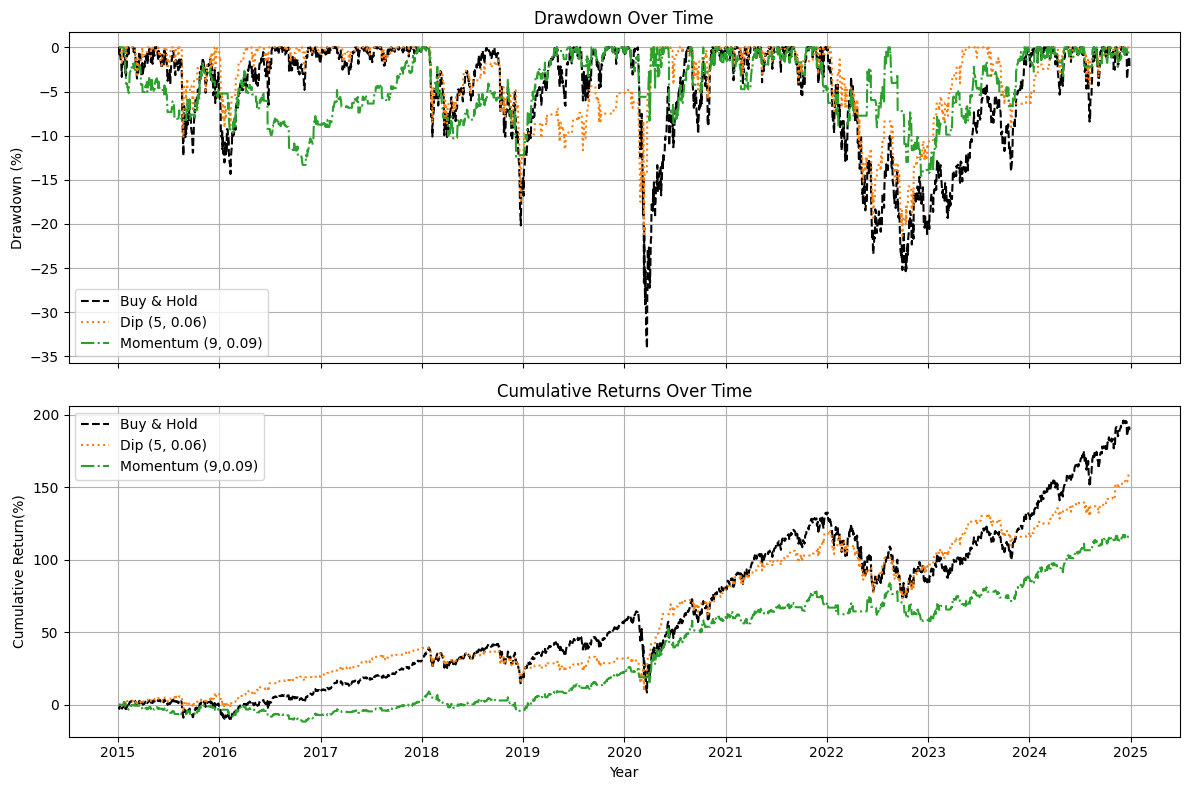

In [5]:
if __name__ == '__main__':
    ticker = input("Enter ticker symbol [SPY (default), NVDA, etc.]: ").upper()
    ticker = ticker if ticker else 'SPY'
    sort = input("Enter sorting metric [CAGR (default), Sharpe, Max Draw]: ")
    start_input = input("Enter start date [MM/DD/YY, default: 1/1/15]: ")
    end_input = input("Enter end date [MM/DD/YY, default: 12/30/24]: ")
    treasury =input("Enter Treasury Yield (defualt: 0%):")
    start_date = parse_date(start_input, '2015-01-01')
    end_date = parse_date(end_input, '2024-12-30')
    data = yf.download(ticker, start=start_date, end=end_date, progress=False,auto_adjust=False)
    data.columns = data.columns.get_level_values(0)
    display_start = datetime.strptime(start_date, "%Y-%m-%d").strftime("%-m/%-d/%y")
    display_end = datetime.strptime(end_date, "%Y-%m-%d").strftime("%-m/%-d/%y")
    print(f"\n{'='*30}")
    print(f"📈 {ticker} from {display_start} to {display_end}".center(30))
    print(f"{'='*30}\n")
    if data.empty:
        print(f"Failed to download data for {ticker} in the specified date range.")
    else:
        if sort == '':
            sort = 'CAGR'
        if treasury == '':
            treasury = 0
        output, best_ride, best_dip, compute = momentum_strategy(data, sort, treasury)
        print(output)
        dip_params = (int(best_dip['Window'].iloc[0]), best_dip['Vol'].iloc[0]) if not best_dip.empty else None
        mom_params = (int(best_ride['Window'].iloc[0]), best_ride['Vol'].iloc[0]) if not best_ride.empty else None
        plot_drawdown(data.copy(), dip=dip_params, momentum=mom_params)